# 📊 AI Data Analyst Agent

### 🤖 Intelligent Insights with LangGraph & Gemini 2.5
**AI Data Analyst** is an advanced conversational agent designed to transform natural language queries into executable data analysis workflows. Orchestrated by **LangGraph** and **LangChain's Experimental Pandas Agent**, this system moves beyond simple chains to create a **stateful, cyclic agent** that can reason, plan, and correct its own code.

Powered by **Google Gemini 2.5**, the agent acts as a virtual data scientist. Instead of manually writing Pandas queries, users simply ask: *"Show me the sales trend over time"* or *"Calculate the correlation between profit and discount."* The agent autonomously generates the code, executes it in a sandbox, and delivers the insight.

---

### 🛠️ Project Workflow
The system utilizes a **LangGraph** state machine to manage the analysis lifecycle:

1.  **Ingestion Node:** Loads structured data (CSV/Excel) and schema info into the graph state.
2.  **Reasoning Node (Gemini):** The LLM analyzes the user query against the schema to formulate a logical plan.
3.  **Code Generation Node:** Translates the plan into executable **Python/Pandas** code.
4.  **Execution Node:** Runs the code. If an error occurs (e.g., syntax error), the graph **loops back** to the reasoning node with the error message for self-correction.
5.  **Visualization:** Renders **Seaborn/Matplotlib** charts directly in the notebook.

---

### 🧰 Tech Stack
* **LLM:** Google Gemini 2.5 Flash Lite
* **Orchestration:** LangGraph (Stateful Agent)
* **Framework:** LangChain
* **Data Manipulation:** Pandas
* **Visualization:** Matplotlib & Seaborn
* **Environment:** Python / Jupyter Notebook

In [1]:
# --------------------------------------------------
# IMPORTS & INITIAL SETUP
# --------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import TypedDict, Any, List, Dict
from dotenv import load_dotenv
import os

# LangChain Imports
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langgraph.graph import StateGraph, END

In [2]:
# --------------------------------------------------
# SETUP & CONFIGURATION
# --------------------------------------------------
load_dotenv(dotenv_path="analyst.env")
Analyst_google_Api_Key = os.getenv("Analyst_GOOGLE_API_KEY")
if Analyst_google_Api_Key:
    os.environ["GOOGLE_API_KEY"] = Analyst_google_Api_Key
else:
    print("WARNING: Google API Key not found in environment variables.")

# Initialize LLM
#gemini-2.0-flash-lite
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite", #gemini-2.0-flash
    temperature=0
)

In [3]:
# ---------------------------------------------------------
# ANALYSIS TOOLS FUNCTIONS
# ---------------------------------------------------------

def plot_correlation_heatmap(df: pd.DataFrame):
    """Generates a heatmap for numeric columns."""
    numeric_df = df.select_dtypes(include=[np.number])
    if numeric_df.empty: return "No numeric columns."
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()
    return "Correlation Heatmap Generated."

def plot_distribution(df: pd.DataFrame, column: str):
    """Histogram for a single numeric column."""
    if column not in df.columns: return f"Column {column} missing."
    
    plt.figure(figsize=(8, 5))
    sns.histplot(df[column], kde=True, color='skyblue')
    plt.title(f"Distribution of {column}")
    plt.show()
    return f"Distribution plot for {column} generated."

def plot_bar_chart(df: pd.DataFrame, x_col: str, hue_col: str = None):
    """
    Generates a Bar Chart.
    - If ONLY x_col is passed: Simple counts.
    - If hue_col is ALSO passed: Grouped bar chart (e.g., Location by Method).
    """
    if x_col not in df.columns: return f"Column {x_col} missing."
    if hue_col and hue_col not in df.columns: return f"Column {hue_col} missing."
    
    plt.figure(figsize=(10, 6))
    
    # Logic to handle Grouping vs Single
    if hue_col:
        # Grouped Bar Chart
        sns.countplot(data=df, x=x_col, hue=hue_col, palette="viridis")
        plt.title(f"Count of {x_col} grouped by {hue_col}")
    else:
        # Single Bar Chart
        order = df[x_col].value_counts().index[:15]
        sns.countplot(data=df, x=x_col, order=order, palette="viridis")
        plt.title(f"Frequency Count of {x_col}")

    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') if hue_col else None
    plt.tight_layout()
    plt.show()
    
    return f"Bar Chart generated for {x_col}" + (f" grouped by {hue_col}." if hue_col else ".")

def plot_boxplot(df: pd.DataFrame, x_col: str, y_col: str):
    """Boxplot: Categorical (x) vs Numerical (y)."""
    if x_col not in df.columns or y_col not in df.columns: return "Columns missing."
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=x_col, y=y_col, palette="Set2")
    plt.title(f"Distribution of {y_col} by {x_col}")
    plt.xticks(rotation=45)
    plt.show()
    return f"Boxplot of {y_col} by {x_col} generated."

def plot_scatter(df: pd.DataFrame, x_col: str, y_col: str):
    """Scatter: Numeric vs Numeric."""
    if x_col not in df.columns or y_col not in df.columns: return "Columns missing."
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=x_col, y=y_col, alpha=0.7)
    plt.title(f"{x_col} vs {y_col}")
    plt.show()
    return f"Scatter plot of {x_col} vs {y_col} generated."

In [4]:
# ---------------------------------------------------------
# ANALYSIS TOOLS FUNCTION MAPPING
# ---------------------------------------------------------
AVAILABLE_TOOLS = {
    "plot_correlation_heatmap": {
        "func": plot_correlation_heatmap,
        "desc": "Show correlation heatmap of all numeric columns.",
        "args": []
    },
    "plot_distribution": {
        "func": plot_distribution,
        "desc": "Show histogram/distribution of ONE numeric column.",
        "args": ["column"]
    },
    "plot_bar_chart": {
        "func": plot_bar_chart,
        "desc": "Show counts for categorical data. Use 'x_col' for the main category. OPTIONAL: Use 'hue_col' to split/group by a second category.",
        "args": ["x_col", "hue_col"]
    },
    "plot_boxplot": {
        "func": plot_boxplot,
        "desc": "Compare a number (y_col) across categories (x_col).",
        "args": ["x_col", "y_col"]
    },
    "plot_scatter": {
        "func": plot_scatter,
        "desc": "Show relationship between TWO numbers.",
        "args": ["x_col", "y_col"]
    }
}

In [5]:
# ---------------------------------------------------------
# STATE DEFINITION
# ---------------------------------------------------------
class AgentState(TypedDict):
    file_path: str
    user_query: str
    df: pd.DataFrame
    
    # AI Decision Output
    selected_tool: str
    tool_args: Dict[str, str]
    final_result: str

In [6]:
# ---------------------------------------------------------
# DATA CLEANER NODE
# ---------------------------------------------------------

def cleaner_node(state: AgentState):
    print("--- 🧹 NODE 1: Smart Data Cleaner ---")
    file_path = state["file_path"]
    
    # 1. Load Data
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    else:
        df = pd.read_excel(file_path)
        
    print(f"   Original Shape: {df.shape}")
    print(f"   Missing Values: {df.isnull().sum().sum()}")
    
    # 2. Iterate and Clean
    for col in df.columns:
        if df[col].isnull().sum() == 0: continue
            
        # A. Numerical Logic
        if pd.api.types.is_numeric_dtype(df[col]):
            # Check Normality (Shapiro-Wilk)
            # Note: For large data, shapiro may fail, so we wrap in try/except or use len check
            clean_data = df[col].dropna()
            if len(clean_data) >= 3:
                stat, p_value = stats.shapiro(clean_data) if len(clean_data) < 5000 else (0, 0)
                
                if p_value > 0.05: # Normal Distribution
                    fill_val = df[col].mean()
                    print(f"   → '{col}' is Normal. Filling with MEAN ({fill_val:.2f})")
                else: # Skewed
                    fill_val = df[col].median()
                    print(f"   → '{col}' is Skewed. Filling with MEDIAN ({fill_val:.2f})")
                
                df[col] = df[col].fillna(fill_val)
        
        # B. Categorical Logic
        else:
            # Check if it's truly categorical (low cardinality)
            if df[col].nunique() < 20 or (df[col].nunique() / len(df) < 0.05):
                mode_val = df[col].mode()[0]
                df[col] = df[col].fillna(mode_val)
                print(f"   → '{col}' is Categorical. Filling with MODE ('{mode_val}')")
    
    # C. Drop Remaining Rows (Text/Dirty Data)
    remaining = df.isnull().sum().sum()
    if remaining > 0:
        print(f"   Dropping {remaining} rows with leftover text nulls.")
        df.dropna(inplace=True)
        
    print(f"   Final Clean Shape: {df.shape}")
    return {"df": df}

In [7]:
# ---------------------------------------------------------
# AI ANALYST SELECTOR NODE
# ---------------------------------------------------------
def analyst_selector_node(state: AgentState):
    print("--- 🧠 NODE 2: AI Analyst Selector ---")
    df = state["df"]
    query = state["user_query"]
    
    # Prepare Prompt Data
    col_info = "\n".join([f"- {col} ({df[col].dtype})" for col in df.columns])
    tool_info = "\n".join([f"- {k}: {v['desc']}" for k, v in AVAILABLE_TOOLS.items()])
    
    prompt = ChatPromptTemplate.from_template(
        """
        You are an Expert Data Analyst.
        
        DATASET COLUMNS:
        {col_info}
        
        AVAILABLE TOOLS:
        {tool_info}
        
        USER QUERY:
        "{query}"
        
        TASK:
        1. Choose the single best tool to visualize/answer the query.
        2. select the exact column names from the dataset to use as arguments.

        CRITICAL RULES:
        - The keys in your "arguments" dictionary MUST EXACTLY MATCH the argument names listed in AVAILABLE TOOLS (e.g. if Args is ['column'], you must use 'column', NOT 'column_name').
        - Do not invent new arguments.
        
        OUTPUT JSON ONLY:
        {{
            "tool_name": "exact_tool_name_from_list",
            "arguments": {{
                "arg_name": "actual_column_name_from_dataset"
            }}
        }}
        """
    )
    
    chain = prompt | llm | JsonOutputParser()
    
    try:
        plan = chain.invoke({"col_info": col_info, "tool_info": tool_info, "query": query})
        print(f"   🤖 Decision: Run '{plan['tool_name']}' on {plan['arguments']}")
        return {"selected_tool": plan['tool_name'], "tool_args": plan['arguments']}
    except Exception as e:
        print(f"   ⚠️ Planning Error: {e}")
        return {"selected_tool": "error", "tool_args": {}}

In [8]:
# ---------------------------------------------------------
# EXECUTION ENGINE NODE
# ---------------------------------------------------------
def execution_node(state: AgentState):
    print("--- ⚙️ NODE 3: Execution Engine ---")
    tool_name = state["selected_tool"]
    args = state["tool_args"]
    df = state["df"]
    
    if tool_name not in AVAILABLE_TOOLS:
        return {"final_result": "Error: Tool not found."}
    
    func = AVAILABLE_TOOLS[tool_name]["func"]
    
    try:
        # Execute the function using the arguments provided by AI
        result = func(df, **args)
        return {"final_result": result}
    except Exception as e:
        return {"final_result": f"Execution Failed: {e}"}

In [9]:
# ---------------------------------------------------------
# GRAPH CONSTRUCTION
# ---------------------------------------------------------
workflow = StateGraph(AgentState)

workflow.add_node("cleaner", cleaner_node)
workflow.add_node("selector", analyst_selector_node)
workflow.add_node("executor", execution_node)

workflow.set_entry_point("cleaner")
workflow.add_edge("cleaner", "selector")
workflow.add_edge("selector", "executor")
workflow.add_edge("executor", END)

app = workflow.compile()
print("AI Data Analyst Agent Ready!")

AI Data Analyst Agent Ready!


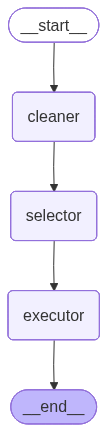

In [10]:
# --------------------------------------------------
# VISUALIZATION: Show the Agent's Flow Chart
# --------------------------------------------------
from IPython.display import Image, display

# Generate the Mermaid diagram
# 'app' is the compiled graph variable from the previous step
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    # This usually happens if you are missing the 'graphviz' or 'pygraphviz' dependency
    print("Could not generate image. Here is the Mermaid syntax instead:")
    print(app.get_graph().draw_mermaid())

--- 🧹 NODE 1: Smart Data Cleaner ---
   Original Shape: (1000, 8)
   Missing Values: 0
   Final Clean Shape: (1000, 8)
--- 🧠 NODE 2: AI Analyst Selector ---
   🤖 Decision: Run 'plot_boxplot' on {'y_col': 'repair_cost', 'x_col': 'defect_type'}
--- ⚙️ NODE 3: Execution Engine ---


/var/folders/n3/1j5nrn9930j2yg8rlrdbgt6c0000gn/T/ipykernel_2428/2278142608.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x_col, y=y_col, palette="Set2")


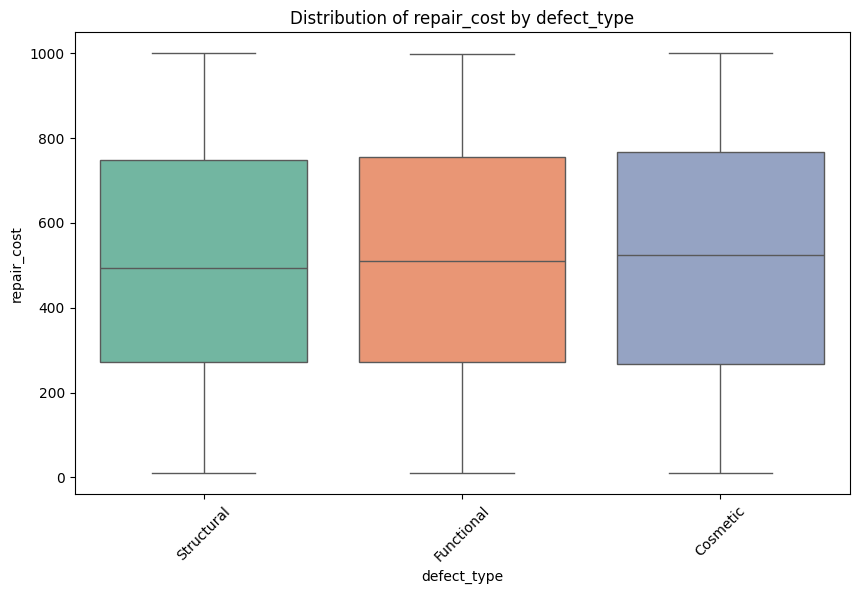


FINAL OUTPUT: Boxplot of repair_cost by defect_type generated.


In [11]:
# ---------------------------------------------------------
#EXAMPLE USAGE
# ---------------------------------------------------------
inputs = {
    "file_path": "defects_data.csv",
    "user_query": "Compare Defect Type by Repair Cost" 
}

result = app.invoke(inputs)
print("\nFINAL OUTPUT:", result["final_result"])

--- 🧹 NODE 1: Smart Data Cleaner ---
   Original Shape: (1000, 8)
   Missing Values: 0
   Final Clean Shape: (1000, 8)
--- 🧠 NODE 2: AI Analyst Selector ---
   🤖 Decision: Run 'plot_bar_chart' on {'x_col': 'defect_location', 'hue_col': 'inspection_method'}
--- ⚙️ NODE 3: Execution Engine ---


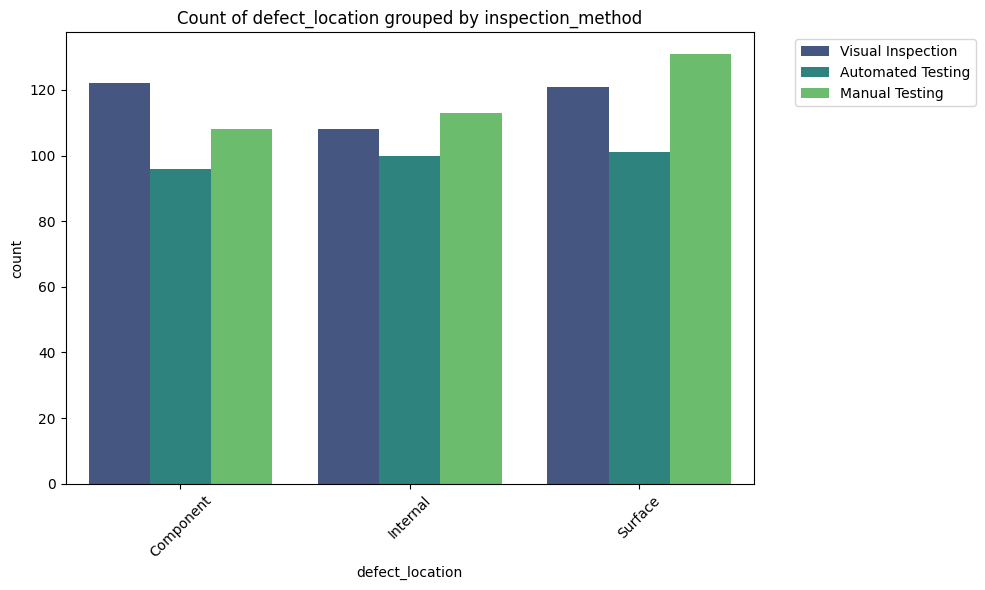


FINAL OUTPUT: Bar Chart generated for defect_location grouped by inspection_method.


In [12]:
inputs = {
    "file_path": "defects_data.csv",
    "user_query": "Provide me analysis of Defect Location and Inspection Method" 
}
result = app.invoke(inputs)
print("\nFINAL OUTPUT:", result["final_result"])

--- 🧹 NODE 1: Smart Data Cleaner ---
   Original Shape: (1000, 8)
   Missing Values: 0
   Final Clean Shape: (1000, 8)
--- 🧠 NODE 2: AI Analyst Selector ---
   🤖 Decision: Run 'plot_distribution' on {'column': 'repair_cost'}
--- ⚙️ NODE 3: Execution Engine ---


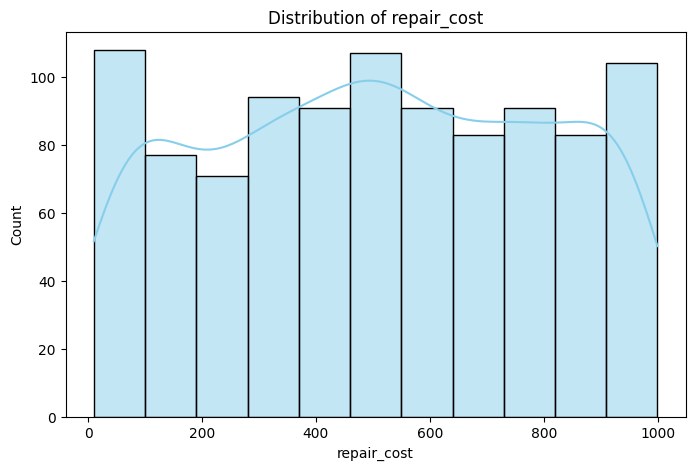

FINAL OUTPUT: Distribution plot for repair_cost generated.


In [13]:
inputs = {
    "file_path": "defects_data.csv",
    "user_query": "Show me the distribution of repair_cost"
}
result = app.invoke(inputs)
print("FINAL OUTPUT:", result['final_result'])

--- 🧹 NODE 1: Smart Data Cleaner ---
   Original Shape: (1000, 8)
   Missing Values: 0
   Final Clean Shape: (1000, 8)
--- 🧠 NODE 2: AI Analyst Selector ---
   🤖 Decision: Run 'plot_bar_chart' on {'x_col': 'defect_type'}
--- ⚙️ NODE 3: Execution Engine ---


/var/folders/n3/1j5nrn9930j2yg8rlrdbgt6c0000gn/T/ipykernel_2428/2278142608.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=x_col, order=order, palette="viridis")


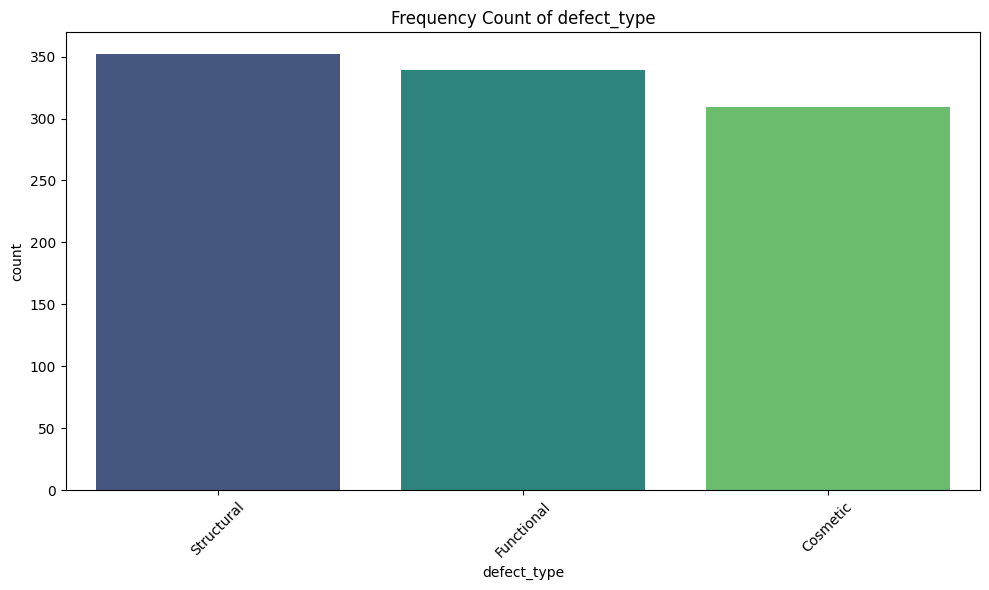

FINAL OUTPUT: Bar Chart generated for defect_type.


In [14]:
inputs = {
    "file_path": "defects_data.csv",
    "user_query": "Count the number of defects for each defect_type"
}
result = app.invoke(inputs)
print("FINAL OUTPUT:", result['final_result'])


🚀 Running TEST 3 (Boxplot)...
--- 🧹 NODE 1: Smart Data Cleaner ---
   Original Shape: (1000, 8)
   Missing Values: 0
   Final Clean Shape: (1000, 8)
--- 🧠 NODE 2: AI Analyst Selector ---
   🤖 Decision: Run 'plot_boxplot' on {'y_col': 'repair_cost', 'x_col': 'severity'}
--- ⚙️ NODE 3: Execution Engine ---


/var/folders/n3/1j5nrn9930j2yg8rlrdbgt6c0000gn/T/ipykernel_2428/2278142608.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x_col, y=y_col, palette="Set2")


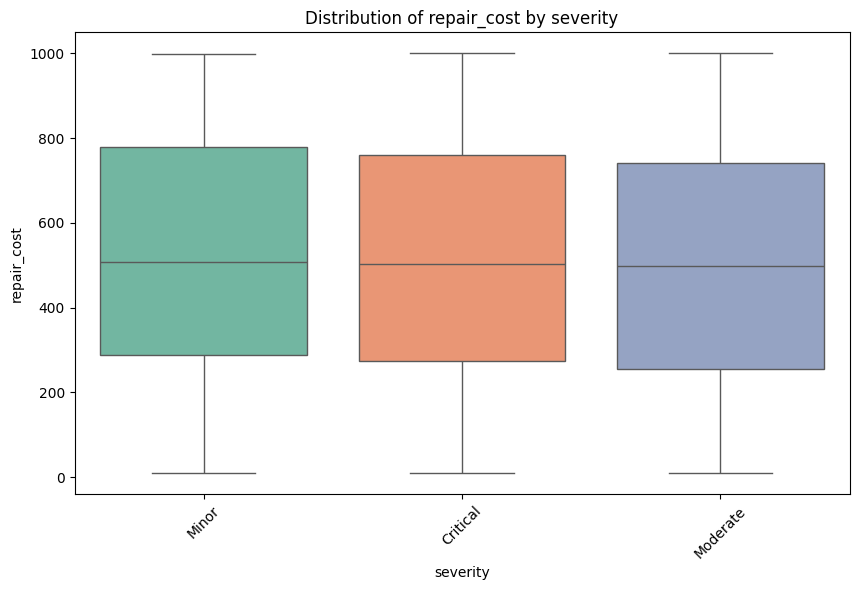

FINAL OUTPUT: Boxplot of repair_cost by severity generated.


In [15]:
inputs = {
    "file_path": "defects_data.csv",
    "user_query": "Compare the repair_cost by severity using a boxplot"
}

print(f"\n🚀 Running TEST 3 (Boxplot)...")
result = app.invoke(inputs)
print("FINAL OUTPUT:", result['final_result'])